In [1]:
import pandas as pd
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import shap
import pickle
from sklearn.cluster import AgglomerativeClustering,DBSCAN
from networkx.algorithms import community
import sklearn_tda as sktda
# Can be downloaded at https://github.com/MathieuCarriere/sklearn-tda
import statmapper as stm
# Can be downloaded at https://github.com/MathieuCarriere/statmapper
from metricmapper import *
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
directory = 'demo_data/diabetes/{}.csv'
X_combine = np.genfromtxt(directory.format('X_combine'),delimiter=',')
pred_combine = np.genfromtxt(directory.format('pred_combine'),delimiter=',')

X = pd.read_csv(directory.format('X')).to_numpy()

X_sample = X_combine[X.shape[0]:,:]
pred_sample = pred_combine[X.shape[0]:]

pred = pred_combine[:X.shape[0]]

## Cost-Based Mapper Optimization

In [3]:
methods = ['IG','DeepSHAP','DeepLIFT']
baselines = ['black','gaussian','mean','train','uniform']

for method in methods:
    for baseline in baselines:
        print(method,baseline)
        exp_combine = np.genfromtxt(directory.format('{}_{}'.format(method,baseline)),delimiter=',')
        exp_combine = scaler.fit_transform(exp_combine)

        exp_sample = exp_combine[X.shape[0]:,:]
        exp = exp_combine[:X.shape[0],:]

        #parameter optimization
        mapper_cand = []
        variance_cand = []
        cc_cand = []
        param_cand = []
        r_cand = [5,10,15,20]
        g_cand = [0.1,0.3,0.5]
        d_cand = [0.5,0.8,1,1.5,2]

        for r in r_cand:
            for g in g_cand:
                for distance in d_cand:
                    cover = HypercubeCover(cover_mode="implicit", 
                                           bnds=np.array([[-1.,1]]), 
                                           resolutions=np.array([r]), 
                                           gains=np.array([g]))
                    params = {'filters':pred_combine.reshape(-1,1),'colors':pred_combine.reshape(-1,1),'codomain':'vectors','cover':cover,'clustering':DBSCAN(eps=distance)}
                    M = MetricMapperComplex(**params).fit(exp_combine)
                    G = stm.mapper2networkx(M)


                    communities_generator = community.girvan_newman(G)
                    n_hierarchy = 3
                    for n in range(n_hierarchy):
                        try:
                            next_level_communities = next(communities_generator)
                        except:
                            pass
                    comm = sorted(map(sorted, next_level_communities))

                    variance = []
                    for bd in comm:
                        pts = set()
                        if type(bd) == list:
                            for b in bd:
                                pts.update(M.node_info_[b]['indices'])
                        else:
                            pts.update(M.node_info_[bd]['indices'])
                        pts=np.array(list(pts))
                        if len(pts) > 10:
                            variance.append(np.var(pred_combine[pts]))
                    mapper_cand.append(M)
                    if len(variance) == 0:
                        variance_cand.append(999)
                    else:
                        variance_cand.append(np.mean(variance))
                    cc_cand.append(nx.number_connected_components(G))
                    param_cand.append((r,g,distance))
        cost = np.array(variance_cand) / np.max(variance_cand[variance_cand!=999]) + np.array(cc_cand)/np.max(cc_cand)
        M = mapper_cand[np.argmin(cost)]
        with open('demo_data/diabetes/config_{}_{}.obj'.format(method,baseline), 'wb') as fp:
            pickle.dump(param_cand[np.argmin(cost)], fp)
            

IG black
IG gaussian
IG mean
IG train
IG uniform
DeepSHAP black
DeepSHAP gaussian
DeepSHAP mean
DeepSHAP train
DeepSHAP uniform
DeepLIFT black
DeepLIFT gaussian
DeepLIFT mean
DeepLIFT train
DeepLIFT uniform


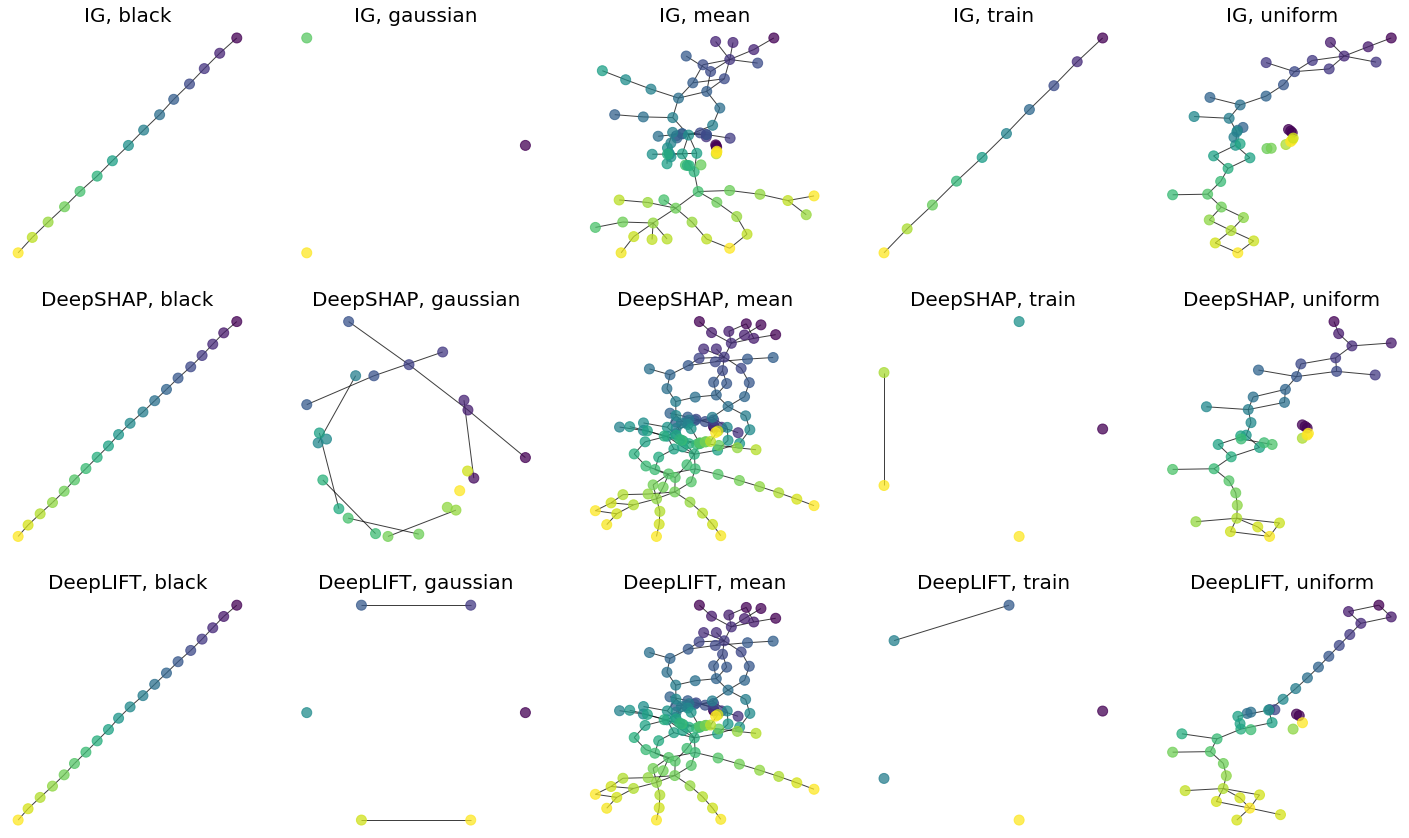

In [42]:
methods = ['IG','DeepSHAP','DeepLIFT']
baselines = ['black','gaussian','mean','train','uniform']
n_rows = 4
n_cols = 5

plt.figure(figsize=(5*n_cols,5*n_rows))

i = 0
j = 1
k=0
graphs = []
for method in methods:
    for baseline in baselines:
        with open('demo_data/diabetes/config_{}_{}.obj'.format(method,baseline), 'rb') as fp:
            r,g,distance = pickle.load(fp)
            exp_combine = np.genfromtxt(directory.format('{}_{}'.format(method,baseline)),delimiter=',')
            exp_combine = scaler.fit_transform(exp_combine)

            exp_sample = exp_combine[X.shape[0]:,:]
            exp = exp_combine[:X.shape[0],:]
            
            cover = HypercubeCover(cover_mode="implicit", 
                                           bnds=np.array([[-1.,1]]), 
                                           resolutions=np.array([r]), 
                                           gains=np.array([g]))
            params = {'filters':pred_combine.reshape(-1,1),'colors':pred_combine.reshape(-1,1),'codomain':'vectors','cover':cover,'clustering':DBSCAN(eps=distance)}
            M = MetricMapperComplex(**params).fit(exp_combine)
            G = stm.mapper2networkx(M)
            plt.subplot(n_rows,n_cols,i*n_cols+j)
            plt.title("{}, {}".format(method,baseline), fontdict = {'fontsize' : 20})
            nx.draw(G, pos=nx.kamada_kawai_layout(G), 
                node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()],node_size=100,alpha=0.75)
            graphs.append(M)
            k+=1
        j += 1 
        if j > n_cols:
            i += 1
            j = 1
plt.savefig('prep_diabetes_networks.png', bbox_inches='tight')

In [7]:
from collections import defaultdict
Ms = []
for mapper in graphs:
    G = stm.mapper2networkx(mapper)
    graph = {'nodes':{},'links':defaultdict(list)}
    for key in mapper.node_info_:
        graph['nodes'][key] = mapper.node_info_[key]['indices']
    for u,v in G.edges:
        graph['links'][u].append(v)
    Ms.append(graph)

In [8]:
from scipy.spatial.distance import cdist
from collections import Counter

def graph_sim(g1,g2,verbose=0):
    n1 = list(g1['nodes'].keys())
    n2 = list(g2['nodes'].keys())
    
    n_nodes = max(np.max([np.max(g1['nodes'][n]) for n in n1]),np.max([np.max(g2['nodes'][n]) for n in n2])) + 1
    
    n1_vec = np.zeros((len(n1),n_nodes))
    for i,n in enumerate(n1):
        n1_vec[i,g1['nodes'][n]] = 1

    
    n2_vec = np.zeros((len(n2),n_nodes))
    for i,n in enumerate(n2):
        n2_vec[i,g2['nodes'][n]] = 1
        
    dist = 1 - cdist(n1_vec,n2_vec,'jaccard')
    n1_correspondence = np.argmax(dist,1)
    n2_correspondence = np.argmax(dist,0)

    if verbose == 1:
        print(np.max(dist,1),np.max(dist,0))
    node_intersection = np.sum(np.max(dist,1)) + np.sum(np.max(dist,0))

    #edge similarity
    n1_hash = {n:i for i,n in enumerate(n1)}
    n2_hash = {n:i for i,n in enumerate(n2)}
    edges = {}
    edge_intersection = 0
    edges_total = 0

    for _n1 in g1['links']:
        for _n2 in g1['links'][_n1]:
            edges[(n1_hash[_n1],n1_hash[_n2])] = 1
            edges_total += 1

    for _n1 in g2['links']:
        for _n2 in g2['links'][_n1]:
            edges_total += 1
            _nc1 = n2_correspondence[n2_hash[_n1]]
            _nc2 = n2_correspondence[n2_hash[_n2]]
            _nc1, _nc2 = np.sort([_nc1, _nc2])
            if (_nc1,_nc2) in edges:
                edge_intersection += 1
                del edges[(_nc1,_nc2)]
                
    graph_similarity = (node_intersection + edge_intersection * 2) / (dist.shape[0] + dist.shape[1] + edges_total)
    return graph_similarity

In [9]:
dist_mat = np.zeros((len(Ms),len(Ms)))
for i in range(len(Ms)):
    for j in range(i+1,len(Ms)):
        sim = graph_sim(Ms[i],Ms[j])
        dist_mat[i,j] = sim
        dist_mat[j,i] = sim
np.savetxt('demo_data/diabetes/similarity.csv', dist_mat, delimiter=",")

In [10]:
opacity = dist_mat.mean(1)
opacity = opacity/ np.max(opacity)

In [33]:
from itertools import product
raw_list = list(product(['IG', 'DeepSHAP', 'DeepLIFT'], baselines))
label_list = []
for an_item in raw_list:
    a_label = f'{an_item[0]}, {an_item[1]}'
    label_list.append(a_label)
ticks = list(range(len(label_list)))

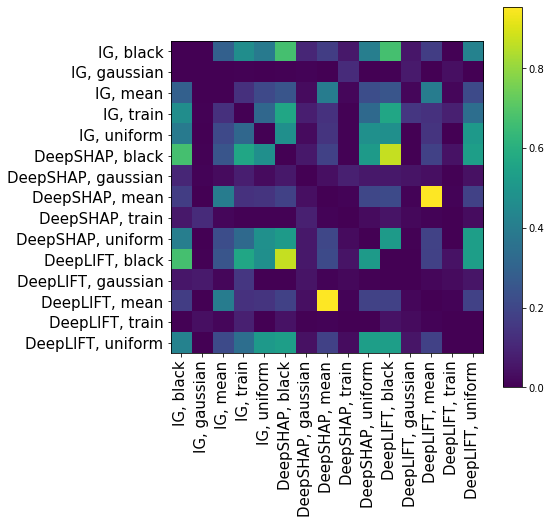

In [38]:
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(dist_mat)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(label_list, fontdict={'fontsize': 15}, rotation = 90)   
ax.set_yticklabels(label_list, fontdict={'fontsize': 15})
cbar = plt.colorbar(im)
plt.savefig('diabetes_mapper_metric.png', bbox_inches='tight')

In [15]:
list(label_list)

[('IG', 'black'),
 ('IG', 'gaussian'),
 ('IG', 'mean'),
 ('IG', 'train'),
 ('IG', 'uniform'),
 ('DeepSHAP', 'black'),
 ('DeepSHAP', 'gaussian'),
 ('DeepSHAP', 'mean'),
 ('DeepSHAP', 'train'),
 ('DeepSHAP', 'uniform'),
 ('DeepLIFT', 'black'),
 ('DeepLIFT', 'gaussian'),
 ('DeepLIFT', 'mean'),
 ('DeepLIFT', 'train'),
 ('DeepLIFT', 'uniform')]